# Generative Spaces (ABM)

In this workshop we will lwarn how to construct a ABM (Agent Based Model) with spatial behaviours, that is capable of configuring the space. This file is a simplified version of Generative Spatial Agent Based Models. For further information, you can find more advanced versions here:

* [Object Oriented version](https://github.com/shervinazadi/spatial_computing_workshops/blob/master/notebooks/w3_generative_spaces.ipynb)
* [Vectorized version](https://topogenesis.readthedocs.io/notebooks/random_walker)

## 0. Initialization

### 0.1. Load required libraries

In [1]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np
from IPython.display import Image
np.random.seed(0)

### 0.2. Define the Neighborhood (Stencil)

In [2]:
# creating neighborhood definition
stencil = tg.create_stencil("von_neumann", 1, 1)
# setting the center to zero
stencil.set_index([0,0,0], 0)
print(stencil)

[[[0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 1 0]
  [1 0 1]
  [0 1 0]]

 [[0 0 0]
  [0 1 0]
  [0 0 0]]]


### 0.3 Visualize the Stencil

In [3]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = np.array(stencil.shape) + 1
# The bottom left corner of the data set
grid.origin = [0,0,0]
# These are the cell sizes along each axis
grid.spacing = [1,1,1]

# Add the data values to the cell data
grid.cell_arrays["values"] = stencil.flatten(order="F")  # Flatten the stencil
threshed = grid.threshold([0.9, 1.1])

# adding the voxels: light red
p.add_mesh(threshed, show_edges=True, color="#ff8fa3", opacity=0.3)

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(7.295554957734411, 7.295554957734411, 7.295554957734411),
 (1.5, 1.5, 1.5),
 (0.0, 0.0, 1.0)]

## 1. Setup the Environment

### 1.1. Load the envelope lattice as the avialbility lattice

In [4]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/voxelized_envelope.csv')
avail_lattice = tg.lattice_from_csv(lattice_path)

### 1.2. Load the Sun Access lattice as the value field

In [5]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/sun_access.csv')
sun_acc_lattice = tg.lattice_from_csv(lattice_path)

### 1.3. Initialize the Agents

In [6]:
# initialize the occupation lattice
occ_lattice = avail_lattice * 0

# Finding the index of the available voxels in avail_lattice
avail_flat = avail_lattice.flatten()
avail_index = np.array(np.where(avail_lattice == 1)).T

# Randomly choosing three available voxels
agn_num = 3
select_id = np.random.choice(len(avail_index), agn_num)
agn_origins = avail_index[select_id]

# adding the origins to the agents locations
agn_locs = []
# for each agent origin ... 
for a_id, a_origin, v_id in zip(range(agn_num), agn_origins, select_id):

    # add the origin to the list of agent locations
    agn_locs.append([a_origin])

    # set the origin in availablity lattice as 0 (UNavailable)
    avail_lattice[tuple(a_origin)] = 0

    # set the origin in ccupation lattice as the agent id (a_id + 1)
    occ_lattice[tuple(a_origin)] = a_id + 1

## 2. ABM Simulation (Agent Based Space Occupation)

### 2.1. Running the simulation

In [7]:
# constructing the new lattice
cur_occ_lattice = tg.to_lattice(np.copy(occ_lattice), occ_lattice)
# initialzing the list of frames
frames = [cur_occ_lattice]

# setting the time variable to 0
t = 0
# main feedback loop of the simulation (for each time step ...)
while t<30:
    # for each agent ... 
    for a_id in range(agn_num):
        # retrieve the list of the locations of the current agent
        a_locs = agn_locs[a_id]
        # initialize the list of free neighbours
        free_neighs = []
        # for each location of the agent
        for loc in a_locs:
            # retrieve the list of neighbours of the agent based on the stencil
            neighs = avail_lattice.find_neighbours_masked(stencil, loc = loc)
            
            # for each neighbour ... 
            for n in neighs:
                # compute 3D index of neighbour
                neigh_3d_id = np.unravel_index(n, avail_lattice.shape)
                # if the neighbour is available... 
                if avail_lattice[neigh_3d_id]:
                    # add the neighbour to the list of free neighbours
                    free_neighs.append(neigh_3d_id)

        # check if found any free neighbour
        if len(free_neighs)>0:            
            # convert free neighbours to a numpy array
            free_neighs = np.array(free_neighs)
            # randomly select one of the available neighbours
            selected_int = np.random.choice(len(free_neighs), 1)
            # find 3D intiger index of selected neighbour
            # selected_neigh_3d_id = np.unravel_index(selected_neigh_id, avail_lattice.shape)
            selected_neigh_3d_id = tuple(free_neighs[selected_int].T)
            # find the location of the newly selected neighbour
            selected_neigh_loc = np.array(selected_neigh_3d_id).flatten()

            # add the newly selected neighbour location to agent locations
            agn_locs[a_id].append(selected_neigh_loc)
            # set the newly selected neighbour as UNavailable (0) in the availability lattice
            avail_lattice[selected_neigh_3d_id] = 0
            # set the newly selected neighbour as OCCUPIED by current agent 
            # (0 means not-occupied so a_id + 1)
            occ_lattice[selected_neigh_3d_id] = a_id + 1

    # constructing the new lattice
    new_occ_lattice = tg.to_lattice(np.copy(occ_lattice), occ_lattice)
    # adding the new lattice to the list of frames
    frames.append(new_occ_lattice)
    # adding one to the time counter
    t += 1

### 2.2. Visualizing the simulation

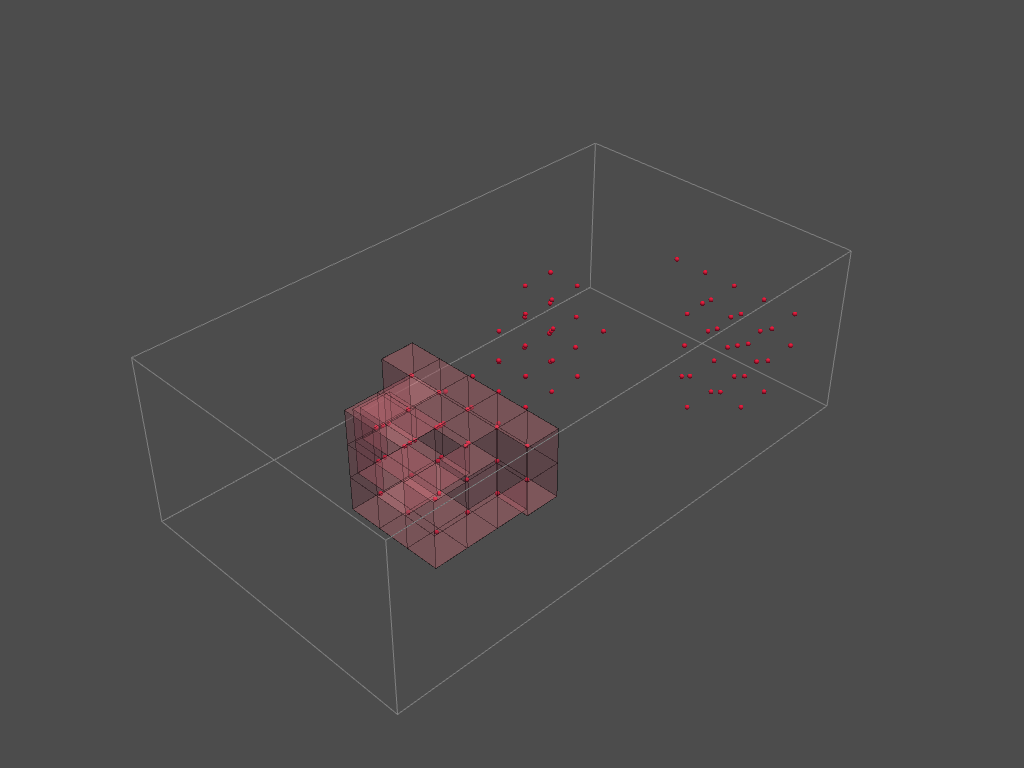

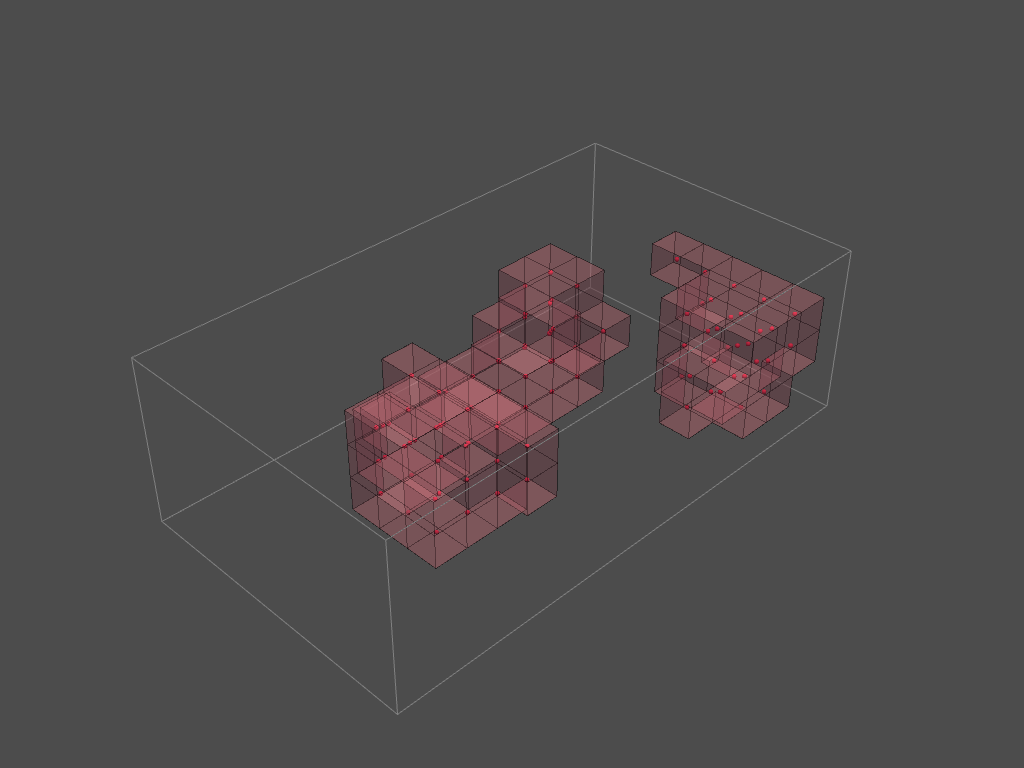

In [8]:
# initiating the plotter
p = pv.Plotter()

# fast visualization of the lattice
frames[0].fast_vis(p)

# setup camera and close
p.show(auto_close=False)

# Open a gif
gif_path = os.path.relpath('../data/abm_random_cccupier.gif')
p.open_gif(gif_path)

# main iteration loop
for lattice in frames:

    # update the plot
    ######
    p.clear()
    l = lattice > 0
    l.fast_vis(p)

    # this will trigger the render
    p.write_frame()

# Close movie and delete object
p.close()

# Show the gif
Image(filename=gif_path)

### 2.3. Saving lattice frames in CSV

In [9]:
for i, lattice in enumerate(frames):
    csv_path = os.path.relpath('../data/abm_animation/abm_f_'+ f'{i:03}' + '.csv')
    lattice.to_csv(csv_path)

### Credits

In [ ]:
__author__ = "Shervin Azadi "
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/spatial_computing_workshops"
__summary__ = "Spatial Computing Design Studio Workshop on Agent Based Models for Generative Spaces"